In [1]:
%load_ext blackcellmagic

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
from utils import seir, run_modified_seir, run_modified_seir_cont
from plot import plot_timeseries_cat, plot_timeseries_cat_2
import matplotlib.pyplot as plt

In [4]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 34

greens = plt.get_cmap('Greens')
purples = plt.get_cmap('Purples')
greys = plt.get_cmap('Greys')
plt.rc('lines',linewidth=2)
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE, frameon=False)    # legend fontsize
#plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
plt.rcParams.update({'axes.spines.top': True, 'axes.spines.right': True})
plt.rcParams['pdf.fonttype'] = 42

# Basic examples

Here we show the types of dynamics that are possible for our modified SEIR model under the different vaccination campaigns.

## 1 
Example of instantaneous vaccination where the two mode of vaccine failures lead to different final outcomes. R0 = 2.5, 50% of the population is vaccinated with a 60% efficacious vaccine at the beginning of the epidemic.

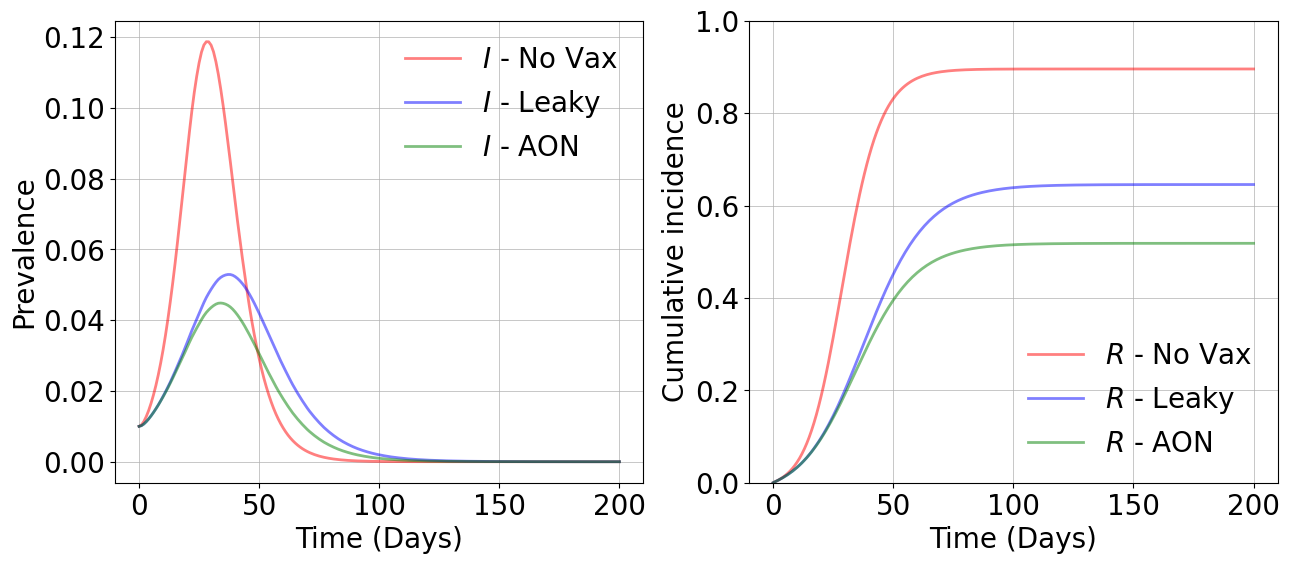

In [5]:
### define parameter values
sigma = 1 / 4
gamma = 1 / 4
R0 = 2.5
beta = R0 * gamma
w = 0
t = 200

# initial conditions based on prior immunity
e0 = 0.01
i0 = 0.01
r0 = 0.00
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.6

# vaccine timing
tv = -1 # before epidemic starts 

# vaccination level
fv = s0 * 0.5

# no vaccination
sol = solve_ivp(
    seir,
    [0, t],
    y0,
    args=(beta, sigma, gamma),
    dense_output=True,
    t_eval=np.linspace(0, t, t + 1),
)

### run model - instantaneous vaccination
# leaky
sim_leaky = run_modified_seir(y0, t, tv, beta, sigma, gamma, w, fv, eps, mode="leaky")

# aon
sim_aon = run_modified_seir(y0, t, tv, beta, sigma, gamma, w, fv, eps, mode="aon")

### plot time-series plot
plt.rcParams["pdf.fonttype"] = 42
fig = plot_timeseries_cat_2(sol.y, sim_leaky, sim_aon)
#plt.savefig('Figures/Example_1.pdf', format='pdf', bbox_inches='tight')

In [4]:
# Final cumulative incidence

print('Final cumulative incidence for no vaccine scenario: %.2f '%sol.y[-1][-1])
print('Final cumulative incidence for leaky vaccine: %.2f '%sim_leaky[-3][-1])
print('Final cumulative incidence for AON vaccine: %.2f '%sim_aon[-3][-1])

Final cumulative incidence for no vaccine scenario: 0.90 
Final cumulative incidence for leaky vaccine: 0.65 
Final cumulative incidence for AON vaccine: 0.52 


## 2
Example of instantaneous vaccination where the two mode of vaccine failures don't lead to very different final outcomes. R0 = 2.5, 50% of the population is vaccinated with a 90% efficacious vaccine at the beginning of the epidemic.

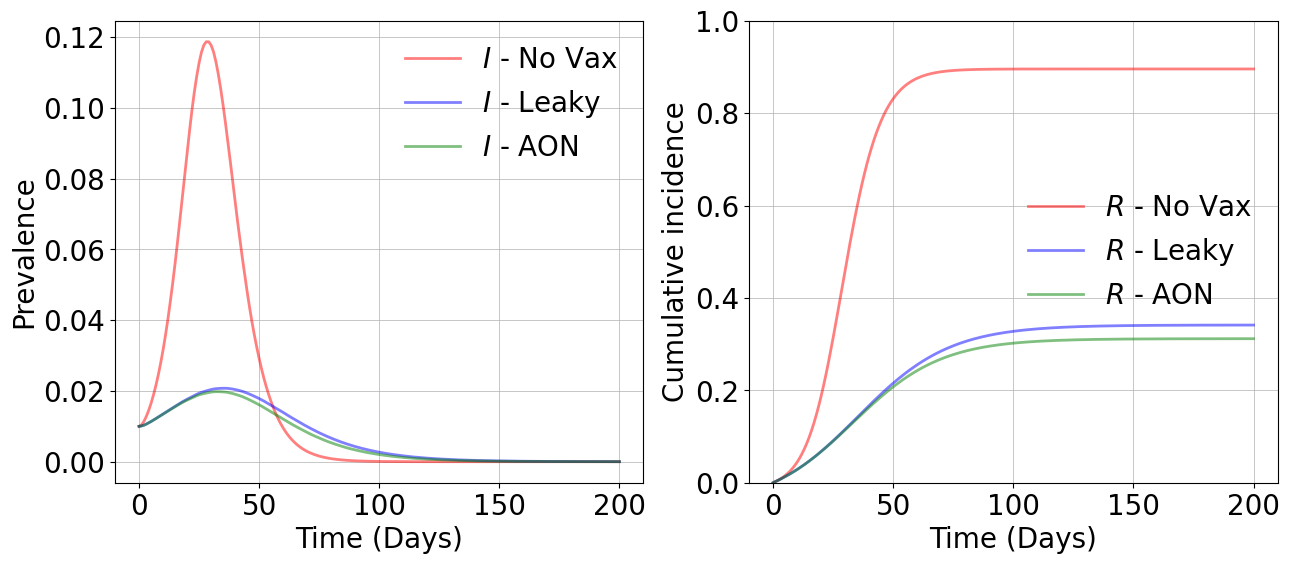

In [5]:
### define parameter values
sigma = 1 / 4
gamma = 1 / 4
R0 = 2.5
beta = R0 * gamma
w = 0
t = 200

# initial conditions based on prior immunity
e0 = 0.01
i0 = 0.01
r0 = 0.00
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.9

# vaccine timing
tv = -1 # before epidemic starts 

# vaccination level
fv = s0 * 0.5

# no vaccination
sol = solve_ivp(
    seir,
    [0, t],
    y0,
    args=(beta, sigma, gamma),
    dense_output=True,
    t_eval=np.linspace(0, t, t + 1),
)

### run model - instantaneous vaccination
# leaky
sim_leaky = run_modified_seir(y0, t, tv, beta, sigma, gamma, w, fv, eps, mode="leaky")

# aon
sim_aon = run_modified_seir(y0, t, tv, beta, sigma, gamma, w, fv, eps, mode="aon")

### plot time-series plot
plt.rcParams["pdf.fonttype"] = 42
fig = plot_timeseries_cat_2(sol.y, sim_leaky, sim_aon)
#plt.savefig('Figures/Example_2.pdf', format='pdf', bbox_inches='tight')

In [6]:
# Final cumulative incidence

print('Final cumulative incidence for no vaccine scenario: %.2f '%sol.y[-1][-1])
print('Final cumulative incidence for leaky vaccine: %.2f '%sim_leaky[-3][-1])
print('Final cumulative incidence for AON vaccine: %.2f '%sim_aon[-3][-1])

Final cumulative incidence for no vaccine scenario: 0.90 
Final cumulative incidence for leaky vaccine: 0.34 
Final cumulative incidence for AON vaccine: 0.31 


## 3
Example of continuous vaccination where the two mode of vaccine failures lead to different final outcomes. R0 = 2.5, 5% of the susceptible population is vaccinated daily after epidemic starts with a 60% efficacious vaccine.

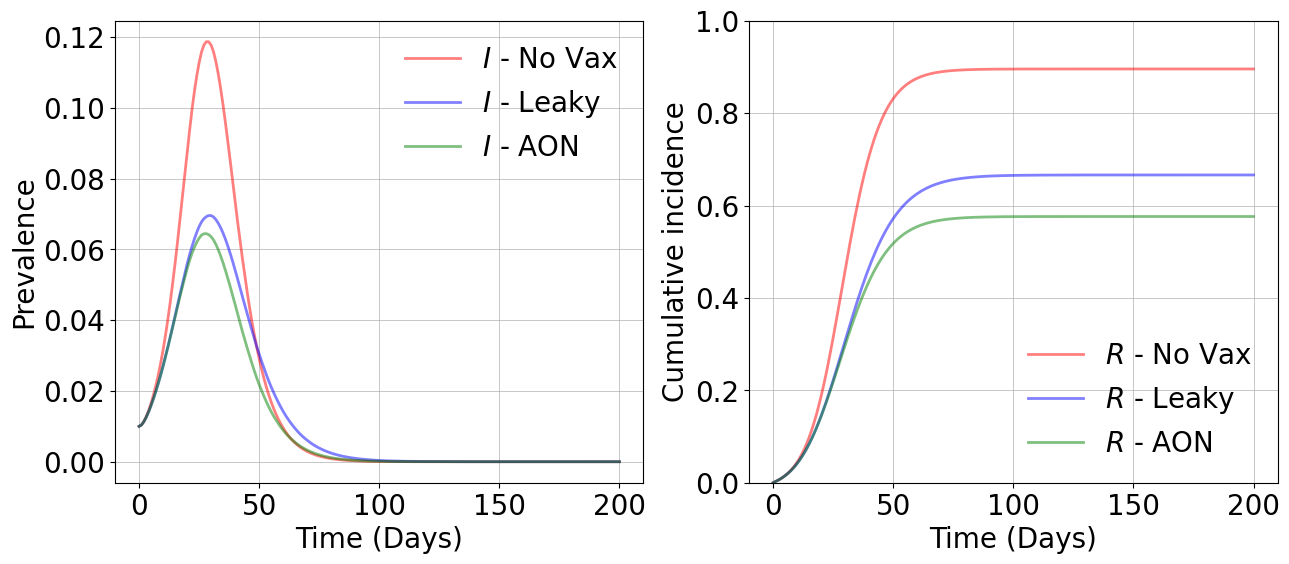

In [8]:
### define parameter values
sigma = 1 / 4
gamma = 1 / 4
R0 = 2.5
beta = R0 * gamma
w = 0
t = 200

# initial conditions based on prior immunity
e0 = 0.01
i0 = 0.01
r0 = 0.00
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.6

# vaccine timing
tv = -1
v = 0.05  # 1% (of susceptible) per day max rate

# vaccination level
fv = s0 * 0.5

# no vaccination
sol = solve_ivp(
    seir,
    [0, t],
    y0,
    args=(beta, sigma, gamma),
    dense_output=True,
    t_eval=np.linspace(0, t, t + 1),
)

### run model - instantaneous vaccination
# leaky
sim_leaky = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="leaky"
)

# aon
sim_aon = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="aon"
)

### plot time-series plot
plt.rcParams["pdf.fonttype"] = 42
fig = plot_timeseries_cat_2(sol.y, sim_leaky, sim_aon)
#plt.savefig("Figures/Example_3.pdf", format="pdf", bbox_inches="tight")

In [9]:
# Final cumulative incidence

print('Final cumulative incidence for no vaccine scenario: %.2f '%sol.y[-1][-1])
print('Final cumulative incidence for leaky vaccine: %.2f '%sim_leaky[-3][-1])
print('Final cumulative incidence for AON vaccine: %.2f '%sim_aon[-3][-1])

Final cumulative incidence for no vaccine scenario: 0.90 
Final cumulative incidence for leaky vaccine: 0.67 
Final cumulative incidence for AON vaccine: 0.58 


## 4
Example of continuous vaccination where the two mode of vaccine failures lead to different final outcomes. R0 = 2.5, 5% of the susceptible population is vaccinated daily after epidemic starts with a 90% efficacious vaccine.

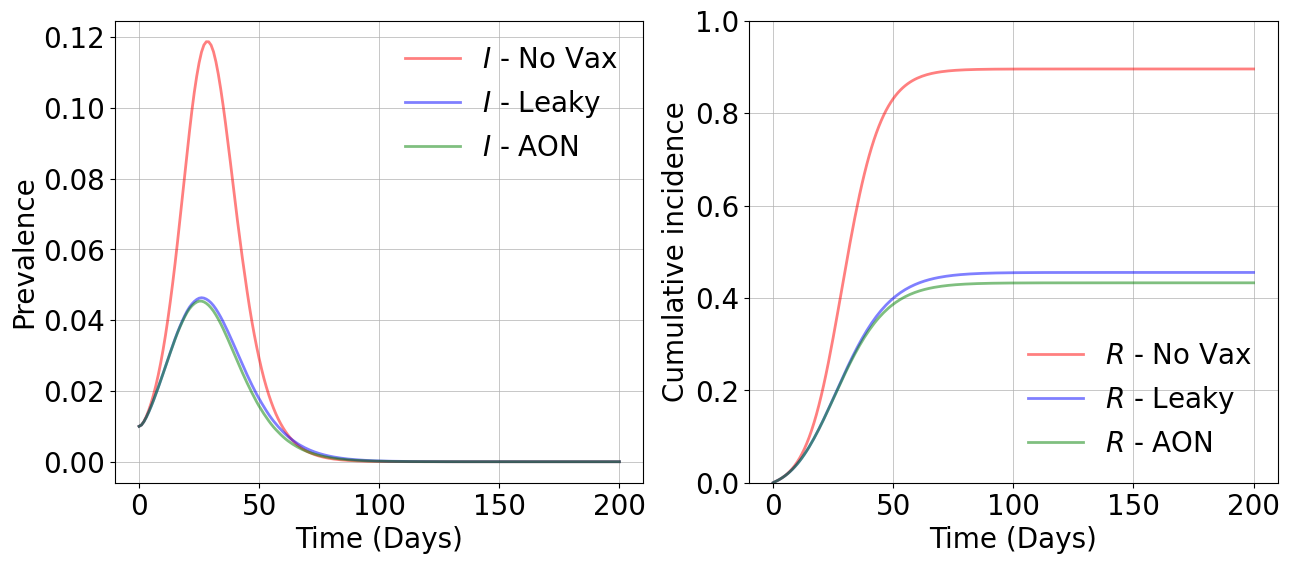

In [10]:
### define parameter values
sigma = 1 / 4
gamma = 1 / 4
R0 = 2.5
beta = R0 * gamma
w = 0
t = 200

# initial conditions based on prior immunity
e0 = 0.01
i0 = 0.01
r0 = 0.00
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.9

# vaccine timing
tv = -1
v = 0.05  # 1% (of susceptible) per day max rate

# vaccination level
fv = s0 * 0.5

# no vaccination
sol = solve_ivp(
    seir,
    [0, t],
    y0,
    args=(beta, sigma, gamma),
    dense_output=True,
    t_eval=np.linspace(0, t, t + 1),
)

### run model - instantaneous vaccination
# leaky
sim_leaky = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="leaky"
)

# aon
sim_aon = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="aon"
)

### plot time-series plot
plt.rcParams["pdf.fonttype"] = 42
fig = plot_timeseries_cat_2(sol.y, sim_leaky, sim_aon)
#plt.savefig("Figures/Example_4.pdf", format="pdf", bbox_inches="tight")

In [11]:
# Final cumulative incidence

print('Final cumulative incidence for no vaccine scenario: %.2f '%sol.y[-1][-1])
print('Final cumulative incidence for leaky vaccine: %.2f '%sim_leaky[-3][-1])
print('Final cumulative incidence for AON vaccine: %.2f '%sim_aon[-3][-1])

Final cumulative incidence for no vaccine scenario: 0.90 
Final cumulative incidence for leaky vaccine: 0.46 
Final cumulative incidence for AON vaccine: 0.43 


# Applying to Real World Examples

Here we use our modified SEIR model to specific scenarios based on real-world vaccination campaigns. Examples 1A, 1B, and 2A are instantaneous vaccine campaigns, while Examples 2B, 3A, and 3B are continuous.[FIX}

## 1

Motivation: A highly effective vaccine is administered before an outbreak but does not have adequate coverage. Delta wave in summer 2021 in US

Prior immunity: 15% (of total population)

Vaccine timing: Pre-epidemic

Vaccination level: 50% (of susceptible population)

Vaccine efficacy: 80%

R0: 2.5

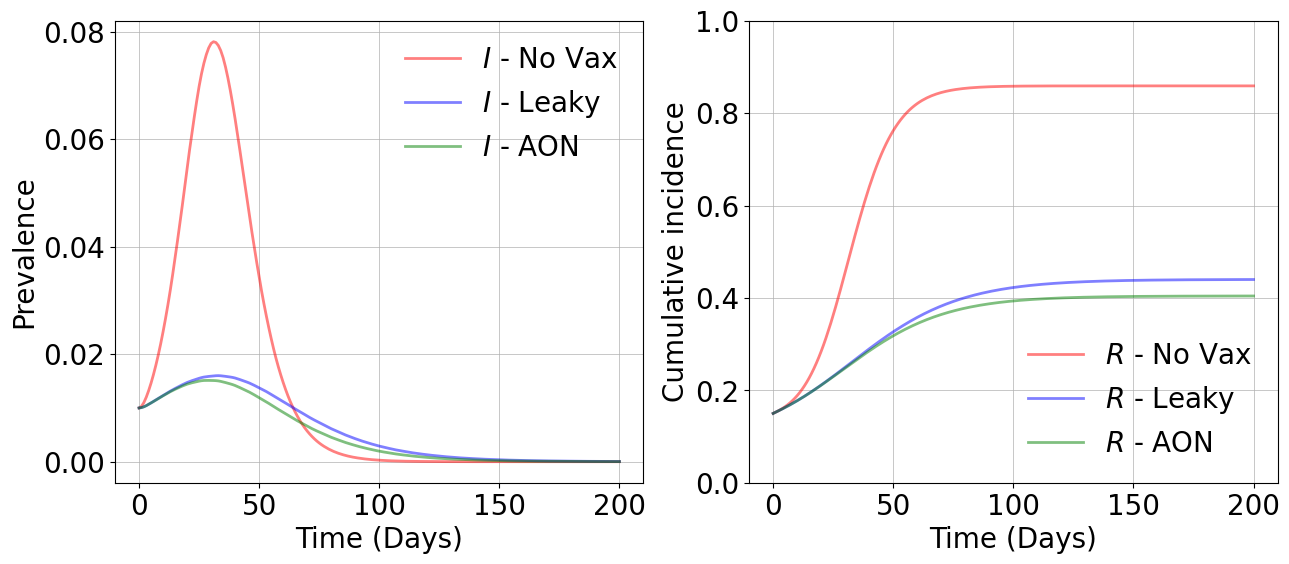

In [8]:
### define parameter values
sigma = 1 / 4
gamma = 1 / 4
R0 = 2.5
beta = R0 * gamma
w = 0
t = 200

# initial conditions based on prior immunity
e0 = 0.01
i0 = 0.01
r0 = 0.15
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.8

# vaccine timing
tv = -1 # before epidemic starts 

# vaccination level
fv = s0 * 0.5

# no vaccination
sol = solve_ivp(
    seir,
    [0, t],
    y0,
    args=(beta, sigma, gamma),
    dense_output=True,
    t_eval=np.linspace(0, t, t + 1),
)

### run model - instantaneous vaccination
# leaky
sim_leaky = run_modified_seir(y0, t, tv, beta, sigma, gamma, w, fv, eps, mode="leaky")

# aon
sim_aon = run_modified_seir(y0, t, tv, beta, sigma, gamma, w, fv, eps, mode="aon")

### plot time-series plot
plt.rcParams["pdf.fonttype"] = 42
fig = plot_timeseries_cat_2(sol.y, sim_leaky, sim_aon)
#plt.savefig('Figures/1A.pdf', format='pdf', bbox_inches='tight')

In [9]:
print('Final cumulative incidence for no vaccine scenario: %.2f '%sol.y[-1][-1])
print('Final cumulative incidence for leaky vaccine: %.2f '%sim_leaky[-3][-1])
print('Final cumulative incidence for AON vaccine: %.2f '%sim_aon[-3][-1])

Final cumulative incidence for no vaccine scenario: 0.86 
Final cumulative incidence for leaky vaccine: 0.44 
Final cumulative incidence for AON vaccine: 0.40 


## 2A

Motivation: Omicron wave in end of 2021/beginning of 2022 in countries with widespread mRNA vaccination campaigns

Prior immunity: 0

Vaccine timing: Pre-epidemic (0% epidemic size)

Vaccination level: 90% (of susceptible population)

Vaccine efficacy: 50%

R0: try to choose an R0 value such that on average about 10% of population is infected each month until epidemic ends (based on vaccinated)

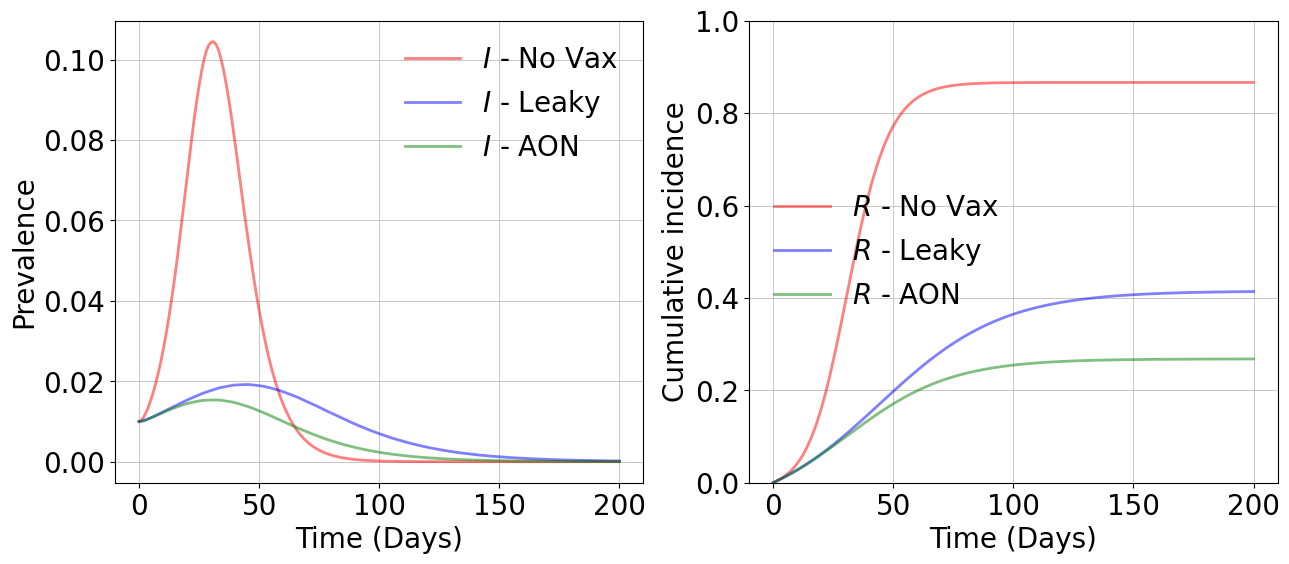

In [9]:
### define parameter values
sigma = 1 / 4
gamma = 1 / 4
R0 = 2.3
beta = R0 * gamma
w = 0
t = 200  # adjust R0
# fc = 1/eps * (1 - 1/R0)

# initial conditions based on prior immunity
e0 = 0.01
i0 = 0.01
r0 = 0.0
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.5

# vaccine timing
tv = -1

# vaccination level
fv = s0 * 0.9

# no vaccination
sol = solve_ivp(
    seir,
    [0, t],
    y0,
    args=(beta, sigma, gamma),
    dense_output=True,
    t_eval=np.linspace(0, t, t + 1),
)

### run model - instantaneous vaccination
# leaky
sim_leaky = run_modified_seir(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, mode="leaky"
)

# aon
sim_aon = run_modified_seir(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, mode="aon"
)

### plot time-series plot
plt.rcParams["pdf.fonttype"] = 42
fig = plot_timeseries_cat_2(sol.y, sim_leaky, sim_aon)
#plt.savefig("Figures/2A.pdf", format="pdf", bbox_inches="tight")

In [11]:
print('Final cumulative incidence for no vaccine scenario: %.2f '%sol.y[-1][-1])
print('Final cumulative incidence for leaky vaccine: %.2f '%sim_leaky[-3][-1])
print('Final cumulative incidence for AON vaccine: %.2f '%sim_aon[-3][-1])

Final cumulative incidence for no vaccine scenario: 0.87 
Final cumulative incidence for leaky vaccine: 0.41 
Final cumulative incidence for AON vaccine: 0.27 


## 2B

Motivation: Omicron wave in end of 2021/beginning of 2022 in countries with widespread mRNA vaccination campaigns (taking into account uncertainty in vaccine efficacy for Omicron)

Prior immunity: 0

Vaccine timing: Pre-epidemic (0% epidemic size)

Vaccination level: 90% (of susceptible population)

Vaccine efficacy: 25%

R0: try to choose an R0 value such that on average about 10% of population is infected each month until epidemic ends (kept the same as 1A)

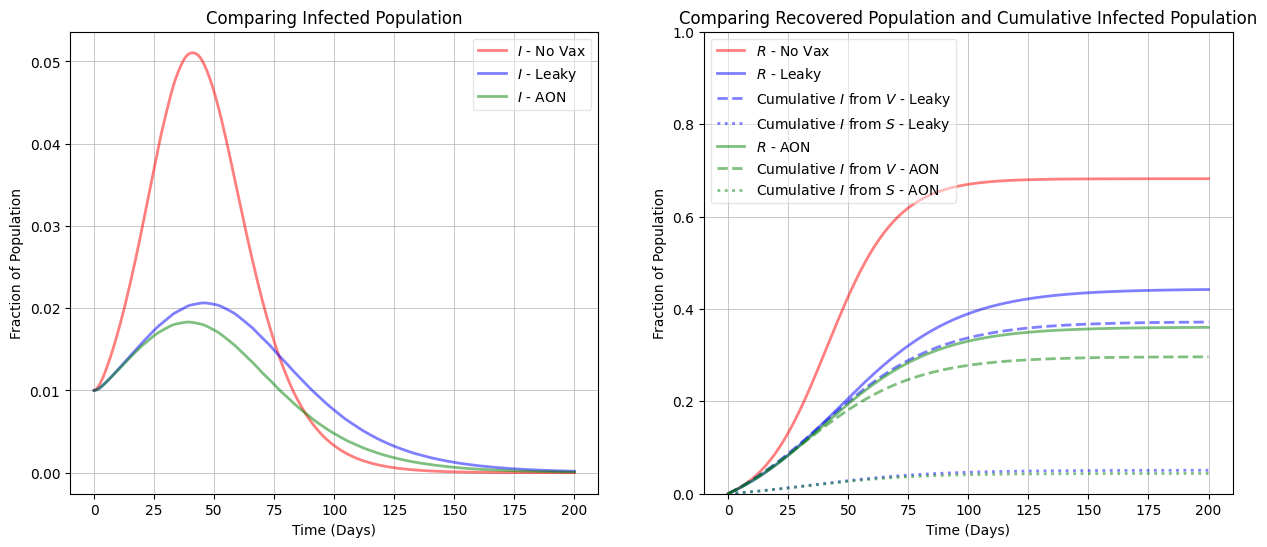

In [23]:
### define parameter values
sigma = 1 / 4
gamma = 1 / 4
R0 = 1.65
beta = R0 * gamma
w = 0
t = 200

# initial conditions based on prior immunity
e0 = 0.01
i0 = 0.01
r0 = 0.0
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.25

# vaccine timing
tv = -1

# vaccination level
fv = s0 * 0.9

# no vaccination
sol = solve_ivp(
    seir,
    [0, t],
    y0,
    args=(beta, sigma, gamma),
    dense_output=True,
    t_eval=np.linspace(0, t, t + 1),
)

### run model - instantaneous vaccination
# leaky
sim_leaky = run_modified_seir(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, mode="leaky"
)

# aon
sim_aon = run_modified_seir(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, mode="aon"
)

### plot time-series plot
plt.rcParams["pdf.fonttype"] = 42
fig = plot_timeseries_cat(sol.y, sim_leaky, sim_aon)
#plt.savefig("Figures/2B.pdf", format="pdf", bbox_inches="tight")

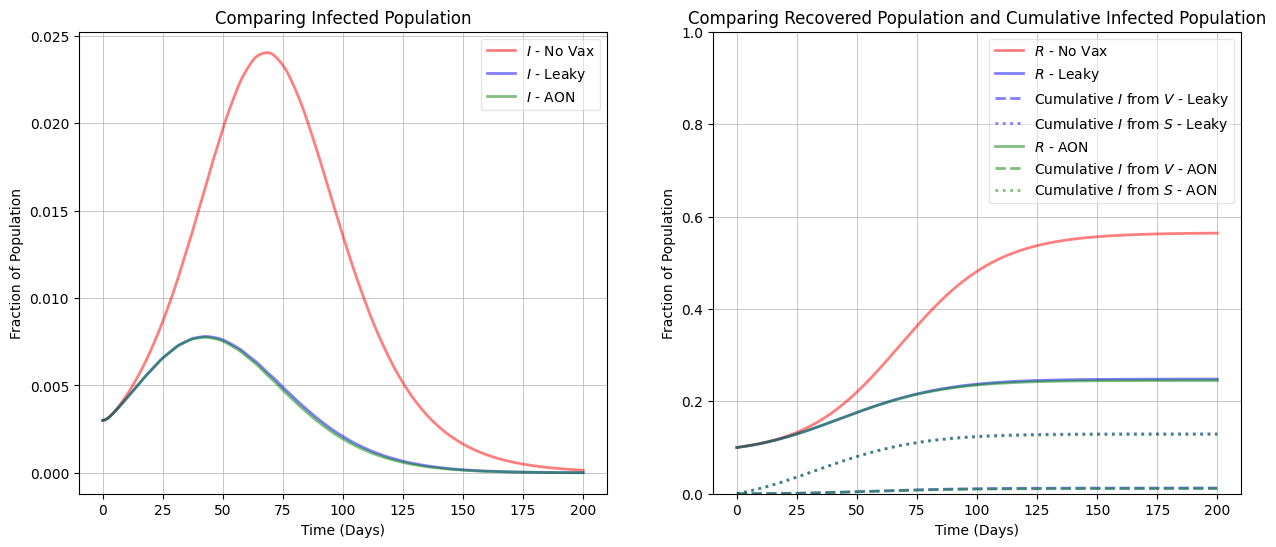

In [24]:
### define parameter values
sigma = 1 / 4
gamma = 1 / 4
R0 = 1.7
beta = R0 * gamma
w = 0
t = 200

# initial conditions based on prior immunity
s0 = 0.84
e0 = 0.003
i0 = 0.003
r0 = 0.1
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.8

# vaccine timing
tv = -1
v = 0.01  # 1% (of susceptible) per day max rate

# vaccination level
fv = s0 * 0.9

# no vaccination
sol = solve_ivp(
    seir,
    [0, t],
    y0,
    args=(beta, sigma, gamma),
    dense_output=True,
    t_eval=np.linspace(0, t, t + 1),
)

### run model - instantaneous vaccination
# leaky
sim_leaky = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="leaky"
)

# aon
sim_aon = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="aon"
)

### plot time-series plot
plt.rcParams["pdf.fonttype"] = 42
fig = plot_timeseries_cat(sol.y, sim_leaky, sim_aon)
#plt.savefig("Figures/3A.pdf", format="pdf", bbox_inches="tight")

## 3A

Motivation: Rapid control of an epidemic wave via vaccination. Similar to Israel WT wave early 2021, Portugal Delta wave summer 2021s

Prior immunity: 10% (of total population)

Vaccine timing: Continous, during-epidemic, at max rate of about 20%/month

Vaccination level: 60% (of susceptible population)

Vaccine efficacy: 90%

R0: 1.7, Reff: 1.5

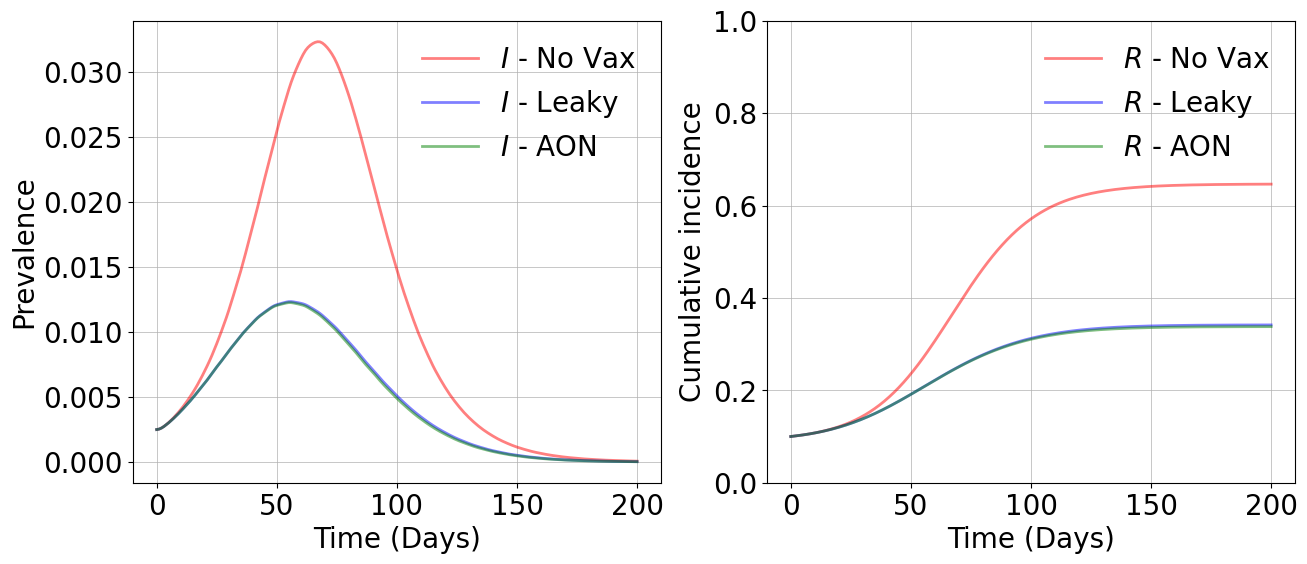

In [10]:
### define parameter values
sigma = 1 / 4
gamma = 1 / 4
R0 = 1.7
beta = R0 * gamma
w = 0
t = 200

# initial conditions based on prior immunity
e0 = 0.0025
i0 = 0.0025
r0 = 0.1
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.9

# vaccine timing
tv = -1
v = 0.2/30 # 1% (of susceptible) per day max rate
# calculated by v*s0 = 0.01, or should it just be v = 0.01?

# vaccination level
fv = s0 * 0.6

# no vaccination
sol = solve_ivp(
    seir,
    [0, t],
    y0,
    args=(beta, sigma, gamma),
    dense_output=True,
    t_eval=np.linspace(0, t, t + 1),
)

### run model - instantaneous vaccination
# leaky
sim_leaky = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="leaky"
)

# aon
sim_aon = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="aon"
)

### plot time-series plot
plt.rcParams["pdf.fonttype"] = 42
fig = plot_timeseries_cat_2(sol.y, sim_leaky, sim_aon)
#plt.savefig("Figures/3A.pdf", format="pdf", bbox_inches="tight")

In [13]:
print('Final cumulative incidence for no vaccine scenario: %.2f '%sol.y[-1][-1])
print('Final cumulative incidence for leaky vaccine: %.2f '%sim_leaky[-3][-1])
print('Final cumulative incidence for AON vaccine: %.2f '%sim_aon[-3][-1])

Final cumulative incidence for no vaccine scenario: 0.65 
Final cumulative incidence for leaky vaccine: 0.34 
Final cumulative incidence for AON vaccine: 0.34 


## 3B

Motivation: Slower control of an epidemic wave via vaccination. 

Prior immunity: 10% (of total population)

Vaccine timing: Continous, during-epidemic, at max rate of about 10%/month

Vaccination level: 60% (of susceptible population)

Vaccine efficacy: 80%

R0: 1.7, Reff: 1.5

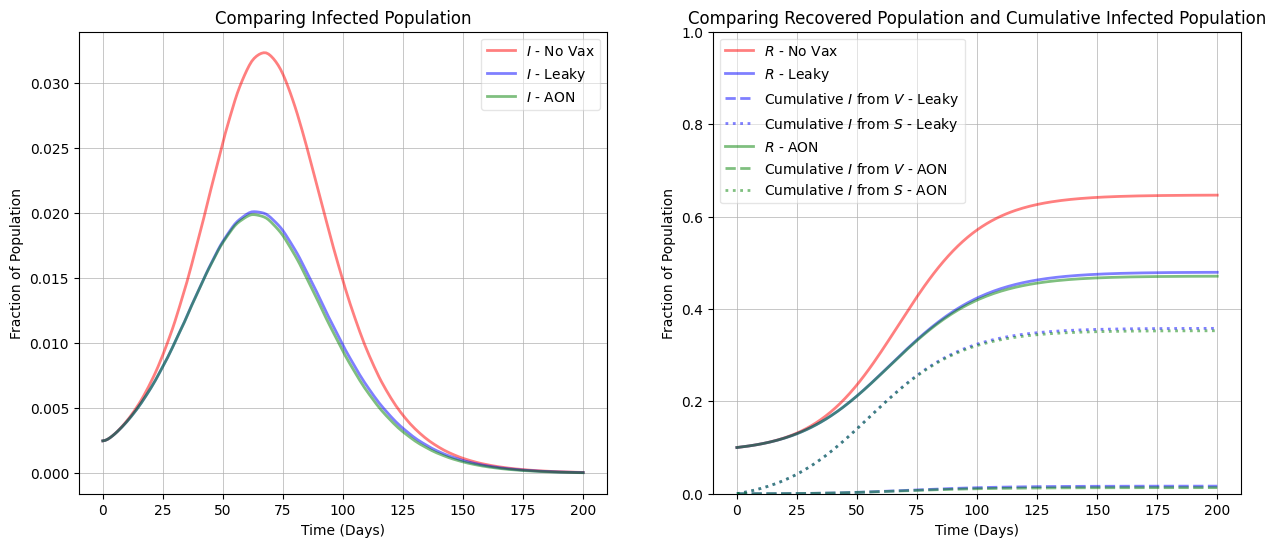

In [26]:
### define parameter values
sigma = 1 / 4
gamma = 1 / 4
R0 = 1.7
beta = R0 * gamma
w = 0
t = 200

# initial conditions based on prior immunity
e0 = 0.0025
i0 = 0.0025
r0 = 0.1
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.8

# vaccine timing
tv = -1
v = 0.1/30 # 1% (of susceptible) per day max rate
# calculated by v*s0 = 0.01, or should it just be v = 0.01?

# vaccination level
fv = s0 * 0.6

# no vaccination
sol = solve_ivp(
    seir,
    [0, t],
    y0,
    args=(beta, sigma, gamma),
    dense_output=True,
    t_eval=np.linspace(0, t, t + 1),
)

### run model - instantaneous vaccination
# leaky
sim_leaky = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="leaky"
)

# aon
sim_aon = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="aon"
)

### plot time-series plot
plt.rcParams["pdf.fonttype"] = 42
fig = plot_timeseries_cat(sol.y, sim_leaky, sim_aon)
plt.savefig("Figures/3B.pdf", format="pdf", bbox_inches="tight")

## 3C

**NOTE: Trying to find a situation where there is continuous vaccination but a big difference between the vaccine failure modes. I thought this would be one but can't seem to get much to happen!**

Motivation: Ongoing spread despite rapid vaccintion to high levels with imperfect vaccine

Prior immunity: 10% (of total population)

Vaccine timing: Continous, during-epidemic, at max rate of about 25%/month

Vaccination level: 85% (of susceptible population)

Vaccine efficacy: 50%

R0: 1.7, Reff: 

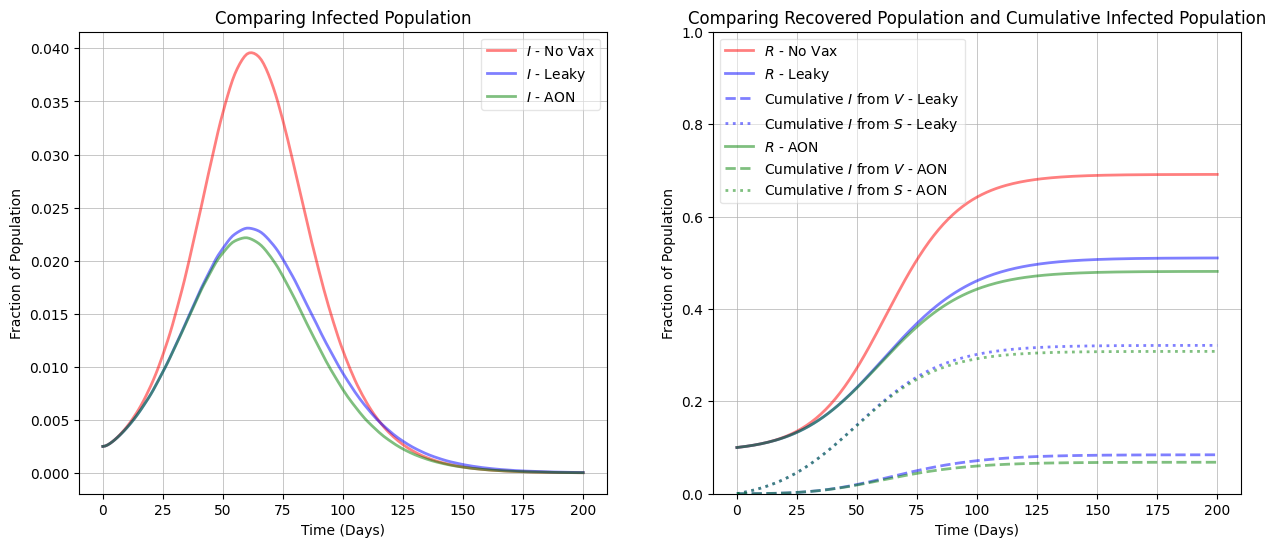

In [27]:
### define parameter values
sigma = 1 / 4
gamma = 1 / 4
R0 = 1.8
beta = R0 * gamma
w = 0
t = 200

# initial conditions based on prior immunity
e0 = 0.0025
i0 = 0.0025
r0 = 0.10
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.5

# vaccine timing
tv = -1
v = 0.25/30 # 1% (of susceptible) per day max rate
# calculated by v*s0 = 0.01, or should it just be v = 0.01?

# vaccination level
fv = s0 * 0.85

# no vaccination
sol = solve_ivp(
    seir,
    [0, t],
    y0,
    args=(beta, sigma, gamma),
    dense_output=True,
    t_eval=np.linspace(0, t, t + 1),
)

### run model - instantaneous vaccination
# leaky
sim_leaky = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="leaky"
)

# aon
sim_aon = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="aon"
)

### plot time-series plot
plt.rcParams["pdf.fonttype"] = 42
fig = plot_timeseries_cat(sol.y, sim_leaky, sim_aon)
plt.savefig("Figures/3C.pdf", format="pdf", bbox_inches="tight")

# Older results

## 2B

Motivation: Delta wave in summer 2021 in India/South Africa

Prior immunity: 50% (of total population)

Vaccine timing: Continous, during-epidemic, over 4 month period (so about 1% per day max rate)

Vaccination level: 50% (of susceptible population)

Vaccine efficacy: 70%

R0: 3, Reff: 1.5

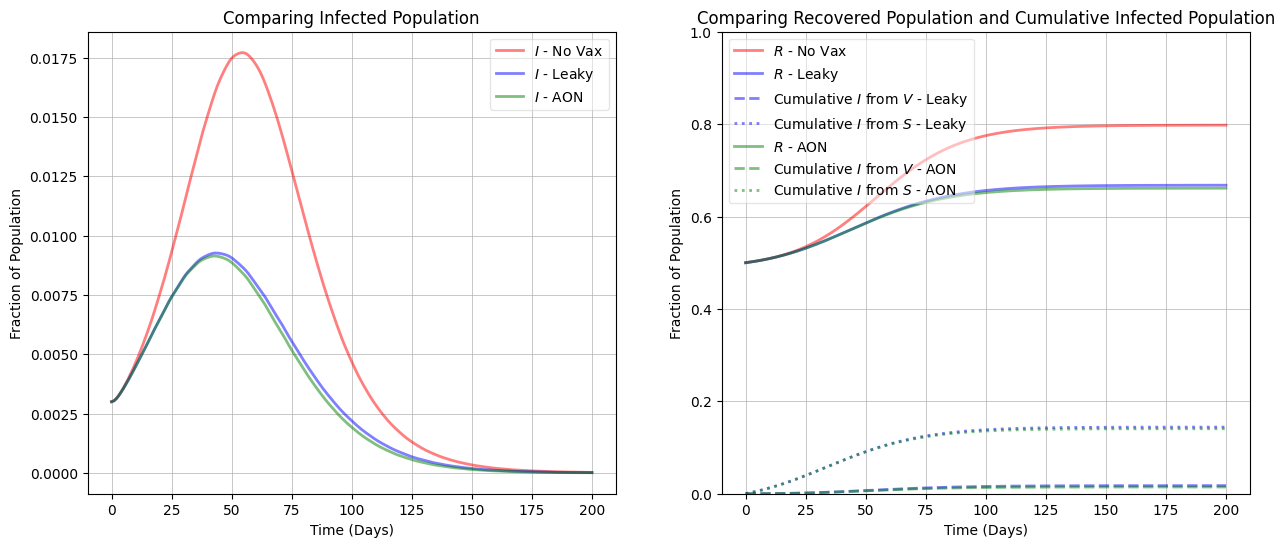

In [28]:
### define parameter values
sigma = 1 / 4
gamma = 1 / 4
R0 = 3
beta = R0 * gamma
w = 0
t = 200

# initial conditions based on prior immunity
s0 = 0.494
e0 = 0.003
i0 = 0.003
r0 = 0.5
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.7

# vaccine timing
tv = -1
v = 0.01  # 1% (of susceptible) per day max rate

# vaccination level
fv = s0 * 0.5

# no vaccination
sol = solve_ivp(
    seir,
    [0, t],
    y0,
    args=(beta, sigma, gamma),
    dense_output=True,
    t_eval=np.linspace(0, t, t + 1),
)

### run model - instantaneous vaccination
# leaky
sim_leaky = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="leaky"
)

# aon
sim_aon = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="aon"
)

### plot time-series plot
plt.rcParams["pdf.fonttype"] = 42
fig = plot_timeseries_cat(sol.y, sim_leaky, sim_aon)
#plt.savefig("Figures/2B.pdf", format="pdf", bbox_inches="tight")

## 3A

Motivation: Near-universal vaccination for epidemic control pre-Omicron. Similar to Portugal, Cuba, Qatar, UAE, etc.

Prior immunity: 10% (of total population)

Vaccine timing: Continous, during-epidemic, over 4 month period (so about 1% per day max rate)

Vaccination level: 90% (of susceptible population)

Vaccine efficacy: 80%

R0: 1.7, Reff: 1.27

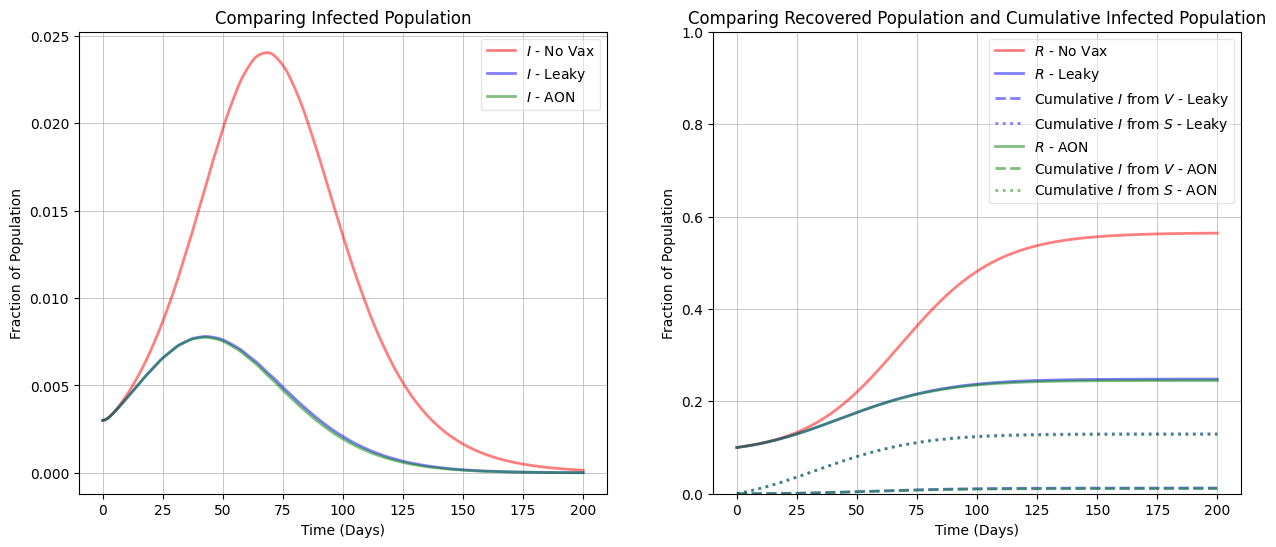

In [29]:
### define parameter values
sigma = 1 / 4
gamma = 1 / 4
R0 = 1.7
beta = R0 * gamma
w = 0
t = 200

# initial conditions based on prior immunity
s0 = 0.84
e0 = 0.003
i0 = 0.003
r0 = 0.1
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.8

# vaccine timing
tv = -1
v = 0.01  # 1% (of susceptible) per day max rate

# vaccination level
fv = s0 * 0.9

# no vaccination
sol = solve_ivp(
    seir,
    [0, t],
    y0,
    args=(beta, sigma, gamma),
    dense_output=True,
    t_eval=np.linspace(0, t, t + 1),
)

### run model - instantaneous vaccination
# leaky
sim_leaky = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="leaky"
)

# aon
sim_aon = run_modified_seir_cont(
    y0, t, tv, beta, sigma, gamma, w, fv, eps, v, mode="aon"
)

### plot time-series plot
plt.rcParams["pdf.fonttype"] = 42
fig = plot_timeseries_cat(sol.y, sim_leaky, sim_aon)
#plt.savefig("Figures/3A.pdf", format="pdf", bbox_inches="tight")